<a href="https://colab.research.google.com/github/Toandinh1/DeepIM/blob/master/212_QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [2]:
import numpy as np
import tensorflow as tf
from scipy.special import binom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.python.ops.gen_math_ops import sign
#from keras import backend as K




N = 2 # number of sub-carriers
K = 1 # number of active sub-carriers
M = 2 # M-ary modulation order

SNRdb = 7 # Training SNR

traing_epochs = 200
l_rate = 0.001
total_batch = 20 # number of batches per epoch
batch_size = 200


n_output_1 = 16
n_output_2 = 32
n_input_1 = N
n_input_2 = 2*N


m = int(np.log2(M))
c = int(np.log2(binom(N,K)))
q = K*m + c # number of bits per OFDM-IM symbol
Q= 2**q
n_output = c

c1 = 4
c2 = 1

SNR = 10**(SNRdb/10)
sigma = np.sqrt(1/SNR)

display_step = 5
qam_factor = (2/3)*(M-1)


a = 1/np.sqrt(2)

# M-ary modulations
if M==4:
    QAM = np.array([1+0j, 0+1j, -0-1j, -1+0j], dtype=complex) # gray mapping
elif M==8:
    QAM = np.array([1, a+a*1j, -a+a*1j, 1j, a-a*1j, -1j, -1, -a-a*1j], dtype=complex) # 8PSK, not 8QAM indeed
    qam_factor = 1
elif M==16:
    QAM = np.array([-3+3j, -3+1j, -3-3j, -3-1j, 
                    -1+3j, -1+1j, -1-3j, -1-1j, 
                    3+3j, 3+1j, 3-3j, 3-1j, 
                    1+3j, 1+1j, 1-3j, 1-1j], dtype=complex)
else:
    QAM = np.array([1+0j,-1+0j], dtype=complex) #BPSK
    qam_factor = 1


# index patterns for N=4 and K=1,2,3 only
if K==1:
    idx = np.array([[0],[1]])
elif K==2:
    idx = np.array([[0,1],[2,3],[0,2],[1,3]]) 
else:
    idx = np.array([[0,1,2],[1,2,3],[0,2,3],[0,1,3]]) 
def SC_IM_NO_train(bit1,bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = sigma*(np.random.normal(0, 1, tx_sym1.shape))
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return y_con
    
  
    

def SC_IM_NO_test(bit1, bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = sigma*(np.random.normal(0, 1, tx_sym1.shape))
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return y_con
    
    



In [3]:
X = tf.placeholder("float", [None, 4])
Y = tf.placeholder("float", [None, 2])
initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    weights = {                    
        'encoder_h1': tf.Variable(initializer([4, 16])),
        'encoder_h2': tf.Variable(initializer([16,32])),
        'encoder_h3': tf.Variable(initializer([32, 2])), 
                   
    }
    biases = {            
        'encoder_b1': tf.Variable(initializer([16])),
        'encoder_b2': tf.Variable(initializer([32])),
        'encoder_b3': tf.Variable(initializer([2])),           
    
    }
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    return layer_3

y_pred = encoder(X)
y_true = Y

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0001 cost= 0.274421183
Epoch: 0006 cost= 0.144004846
Epoch: 0011 cost= 0.080092413
Epoch: 0016 cost= 0.037918270
Epoch: 0021 cost= 0.018307884
Epoch: 0026 cost= 0.010477389
Epoch: 0031 cost= 0.007037546
Epoch: 0036 cost= 0.006003196
Epoch: 0041 cost= 0.004532359
Epoch: 0046 cost= 0.003609034
Epoch: 0051 cost= 0.003104694
Epoch: 0056 cost= 0.002448673
Epoch: 0061 cost= 0.002277152
Epoch: 0066 cost= 0.001932819
Epoch: 0071 cost= 0.002048902
Epoch: 0076 cost= 0.001663000
Epoch: 0081 cost= 0.001458266
Epoch: 0086 cost= 0.001404084
Epoch: 0091 cost= 0.001349888
Epoch: 0096 cost= 0.001261642
Epoch: 0101 cost= 0.001631634
Epoch: 0106 cost= 0.000924391
Epoch: 0111 cost= 0.001220122
Epoch: 0116 cost= 0.001131130
Epoch: 0121 cost= 0.000962338
Epoch: 0126 cost= 0.000840862
Epoch: 0131 cost= 0.000917953
Epoch: 0136 cost= 0.001178980
Epoch: 0141 cost= 0.000725992
Epoch: 0146 cost= 0.000774293
Epoch: 0151 cost= 0.000661689
Epoch: 0156 cost= 0.000874632
Epoch: 0161 cost= 0.000970482
Epoch: 016

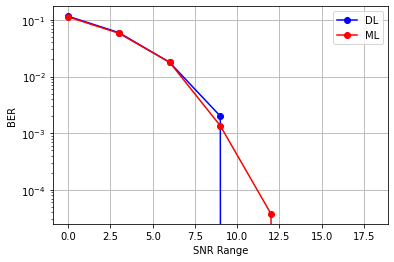

In [5]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_samples1 = []
            input_labels = []
            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput = SC_IM_NO_train(bits1,bits2,10)
                input_labels.append(bits1)
                input_samples.append(signaloutput)
                
               

            batch_x = np.asarray(input_samples)
            batch_y = np.asarray(input_labels)
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_x,
                                                        Y:batch_y,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_samples1_test = []
      input_labels_test = []
      test_number = 10000
      if n>3:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_labels_test.append(bits1)
        input_samples_test.append(signaloutput)
        
               

      batch_x = np.asarray(input_samples_test)
      batch_y = np.asarray(input_labels_test)
      
      mean_error_rate = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_y-0.5),tf.float32))),1))
      BER1[n]  = mean_error_rate.eval({X:batch_x})
      print("SNR=", EbNodB_range[n], "BER:", BER1[n])
    ML1 = [0.113062500000000,	0.0580625000000000,	0.0178875000000000,	0.00135000000000000	,3.75000000000000e-05,	0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER1, 'bo-',label='DL')
    plt.plot(EbNodB_range, ML1, 'ro-',label='ML')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()

In [7]:
X = tf.placeholder("float",[None, 4])
y_pred = encoder(X)
X1 = tf.concat((y_pred,X),axis=-1)
Y1 = tf.placeholder("float",[None, 2])
Y2 = tf.placeholder("float",[None, 2])
initializer = tf.contrib.layers.xavier_initializer()

def encoder1(a):
    weights = {
        'encoder_h1': tf.Variable(initializer([6, 32])),
        'encoder_h2': tf.Variable(initializer([32, 64])),
        'encoder_h3': tf.Variable(initializer([64, 2])),
        
    }
    
    biases = {
        'encoder_b1': tf.Variable(initializer([32])),
        'encoder_b2': tf.Variable(initializer([64])),
        'encoder_b3': tf.Variable(initializer([2])),
        
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(a, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
   
    return layer_3


y2_pred = encoder1(X1)
y2_true = Y1
y_true = Y2

cost = tf.reduce_mean(tf.pow(y2_true - y2_pred,2)+tf.pow(y_true - y_pred,2))


learning_rate = tf.placeholder(tf.float32,shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

Epoch: 0001 cost= 0.522996965
Epoch: 0006 cost= 0.305138624
Epoch: 0011 cost= 0.178137795
Epoch: 0016 cost= 0.098960420
Epoch: 0021 cost= 0.053915116
Epoch: 0026 cost= 0.031492366
Epoch: 0031 cost= 0.019230502
Epoch: 0036 cost= 0.014956646
Epoch: 0041 cost= 0.012539571
Epoch: 0046 cost= 0.009624189
Epoch: 0051 cost= 0.008149032
Epoch: 0056 cost= 0.007057920
Epoch: 0061 cost= 0.007424070
Epoch: 0066 cost= 0.006220106
Epoch: 0071 cost= 0.006516433
Epoch: 0076 cost= 0.005073751
Epoch: 0081 cost= 0.005250993
Epoch: 0086 cost= 0.004607637
Epoch: 0091 cost= 0.004889354
Epoch: 0096 cost= 0.004727271
Epoch: 0101 cost= 0.004484853
Epoch: 0106 cost= 0.003947297
Epoch: 0111 cost= 0.004435214
Epoch: 0116 cost= 0.003514438
Epoch: 0121 cost= 0.003625306
Epoch: 0126 cost= 0.003721711
Epoch: 0131 cost= 0.002881876
Epoch: 0136 cost= 0.004862280
Epoch: 0141 cost= 0.003545626
Epoch: 0146 cost= 0.003351338
Epoch: 0151 cost= 0.003386991
Epoch: 0156 cost= 0.003331438
Epoch: 0161 cost= 0.003168861
Epoch: 016

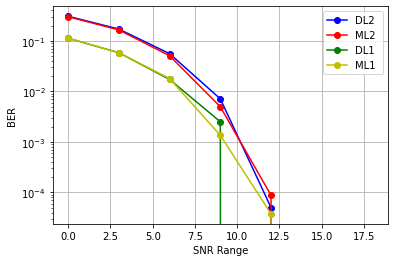

In [9]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)
BER2 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_labels  = []
            input_labels1 = []
            

            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput = SC_IM_NO_train(bits1,bits2,10)
                input_samples.append(signaloutput)
                input_labels.append(bits2)
                input_labels1.append(bits1)
                

            batch_1 = np.asarray(input_samples)
            batch_2 = np.asarray(input_labels)
            batch_3 = np.asarray(input_labels1)
            
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_1,
                                                        Y1:batch_2,Y2:batch_3,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_labels_test = []
      input_labels1_test = []
      
      test_number = 10000
      if n>10:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_samples_test.append(signaloutput)
        input_labels_test.append(bits2)
        input_labels1_test.append(bits1)
       
               

      batch_1 = np.asarray(input_samples_test)
      batch_2 = np.asarray(input_labels_test)
      batch_3 = np.asarray(input_labels1_test)
      
      mean_error_rate1 = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_3-0.5),tf.float32))),1))
      BER1[n]  = mean_error_rate1.eval({X:batch_1,Y2:batch_3})
      print("SNR1=", EbNodB_range[n], "BER1:", BER1[n])
      
      mean_error_rate2 = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y2_pred-0.5), tf.cast(tf.sign(batch_2-0.5),tf.float32))),1))
      BER2[n]  = mean_error_rate2.eval({X:batch_1,Y1:batch_2,Y2:batch_3})
      print("SNR2=", EbNodB_range[n], "BER2:", BER2[n])
    ML1 = [0.113062500000000,	0.0580625000000000,	0.0178875000000000,	0.00135000000000000	,3.75000000000000e-05,	0,	0]
    ML2=[0.299487500000000,	0.164262500000000	,0.0505875000000000	,0.00495000000000000	,8.75000000000000e-05	,0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER2, 'bo-',label='DL2 ')
    plt.plot(EbNodB_range, ML2, 'ro-',label='ML2 ')
    plt.plot(EbNodB_range, BER1, 'go-',label='DL1 ')
    plt.plot(EbNodB_range, ML1, 'yo-',label='ML1 ')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()